In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

# Forecasting Returns: Read Historical Daily CAD/JPY Exchange Rate Data
After reading in historical daily CAD/JPY exchange rate futures data, I will apply several time series analyses and modeling to determine whether there is any predictable behavior in past prices and/or volatility.


In [2]:
# Currency pair exchange rates for CAD/JPY
cad_jpy_df = pd.read_csv(
    Path("cad_jpy.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1982-01-05,184.65,184.65,184.65,184.65
1982-01-06,185.06,185.06,185.06,185.06
1982-01-07,186.88,186.88,186.88,186.88
1982-01-08,186.58,186.58,186.58,186.58
1982-01-11,187.64,187.64,187.64,187.64


In [3]:
# Trim the dataset to begin on January 1st, 1990
cad_jpy_df = cad_jpy_df.loc["1990-01-01":, :]
cad_jpy_df.head()

,Price,Open,High,Low
Date,,,,
1990-01-02,126.37,126.31,126.37,126.31
1990-01-03,125.30,125.24,125.30,125.24
1990-01-04,123.46,123.41,123.46,123.41
1990-01-05,124.54,124.48,124.54,124.48
1990-01-08,124.27,124.21,124.27,124.21


 # Forecasting Returns: Initial Time-Series Plotting

Text(0.5, 1.0, 'CAD/JPY Exchange Rates')

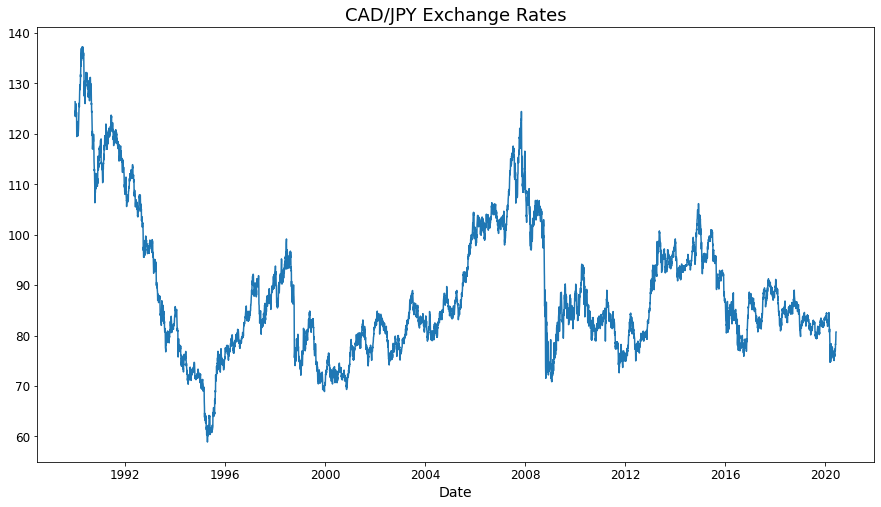

In [4]:
# Plotting just the price column from the dataframe:

plt.subplots(figsize=(15,8))
plt.plot(cad_jpy_df.Price)
plt.xlabel("Date", fontdict={'fontsize':'14'})
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.title(f"CAD/JPY Exchange Rates", fontdict={'fontsize':'18'})


### Initial identifications of Trends/Fluctuations for CAD/JPY:
 * Based on the plot above, we can see a long-term strengthening of the Japanese Yen respective to the Canadian Dollar. However, there's been several periods of trending strength for CAD, namely 2000 to 2008 and then post the Great Financial Crisis, as the Bank of Japan heavily stimulated the economy through expansionary monetary policy - deliberately pushing down the Yen. This trend reversed again as the Oil price collapsed in 2014 and CAD began to trend weaker. 

---

# Decomposition of CAD/JPY Using a Hodrick-Prescott Filter (HP Filter)

 Using a Hodrick-Prescott Filter, I will decompose the exchange rate price into trend and noise components.

In [5]:
import statsmodels.api as sm

exchange_noise, exchange_trend = sm.tsa.filters.hpfilter(cad_jpy_df["Price"])

In [6]:
# Here I created a dataframe of just the exchange rate price, and added columns for "noise" and "trend" series from above:
cad_jpy_price_df = cad_jpy_df["Price"].to_frame()
cad_jpy_price_df["Noise"] = exchange_noise
cad_jpy_price_df["Trend"] = exchange_trend

cad_jpy_price_df.head()

,Price,Noise,Trend
Date,,,
1990-01-02,126.37,0.519095,125.850905
1990-01-03,125.30,-0.379684,125.679684
1990-01-04,123.46,-2.048788,125.508788
1990-01-05,124.54,-0.798304,125.338304
1990-01-08,124.27,-0.897037,125.167037


Text(0.5, 1.0, 'Price vs. Trend')

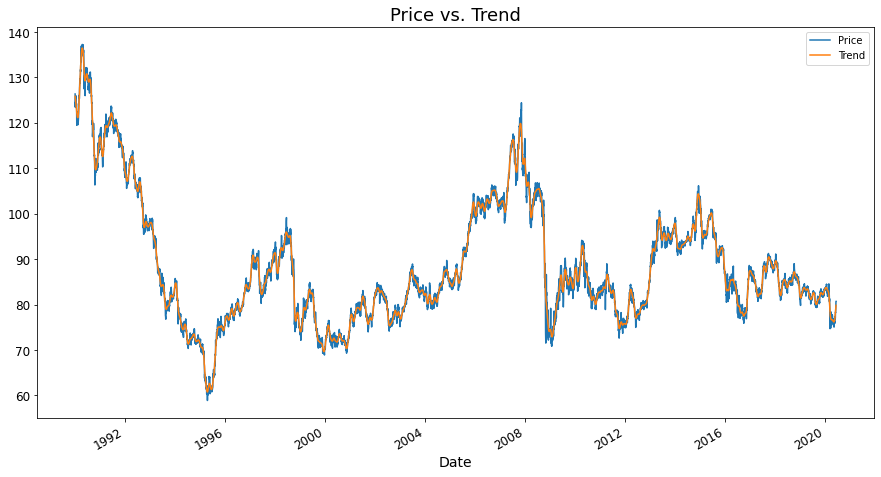

In [7]:
# Plotting the exchange rate Price vs. the Trend

cad_jpy_price_df.plot(y=["Price", "Trend"], figsize=(15,8))
plt.xlabel("Date", fontdict={'fontsize':'14'})
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend()
plt.title(f"Price vs. Trend", fontdict={'fontsize':'18'})



Smoothing with the HP Filter and plotting the resulting trend against the actual futures returns, we can see that there's a lot of short term fluctuations that deviate around this trend. Perhaps these would represent profitable trading opportunities: For example, when the blue line deviates far below the orange, we can see this as a sign that the Yen is temporarily more undervalued than it should be (and, therefore, we'd see this as a short-term buying opportunity).

Text(0.5, 1.0, 'Noise')

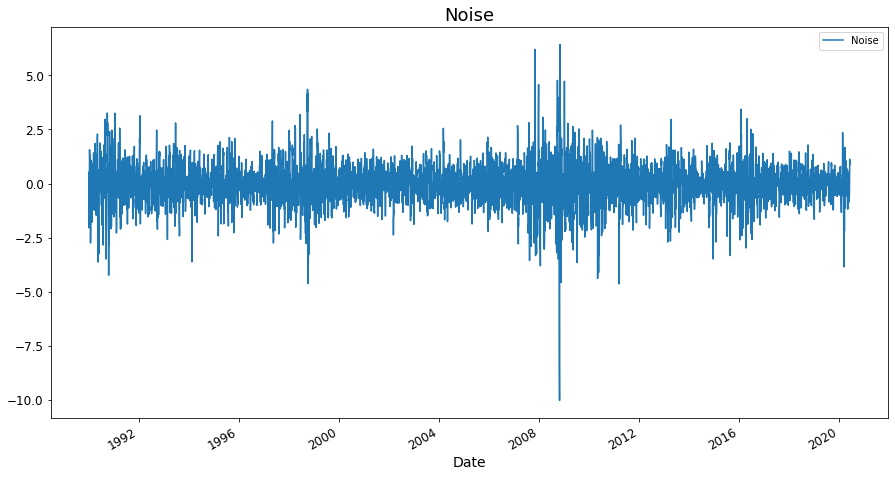

In [8]:
# Plot the Price Noise
cad_jpy_price_df["Noise"].plot(figsize=(15,8))
plt.xlabel("Date", fontdict={'fontsize':'14'})
plt.xticks(size = 12)
plt.yticks(size = 12)
plt.legend()
plt.title(f"Noise", fontdict={'fontsize':'18'})

---

# Returns Forecasting using an ARMA Model

After calculate daily returns based on the exchange rate price data, I use the ARMA model to forecast future returns.
Step by Step Plan:
1. Create an ARMA model and fit it to the returns data. I will set the AR and MA ("p" and "q") parameters to p=2 and q=1: order=(2, 1).
2. Output the ARMA summary table and take note of the p-values of the lags. Based on the p-values, is the model a good fit (p < 0.05)?
3. Plot the 5-day forecast of the forecasted returns (the results forecast from ARMA model)

In [9]:
# First I created a series using "Price" percentage returns, I drop any nan"s, and check the results. I also multipy the returns by 100 to make it clearer:
returns = (cad_jpy_df[["Price"]].pct_change() * 100)
returns = returns.replace(-np.inf, np.nan).dropna()
returns.tail()

,Price
Date,
2020-05-29,0.076697
2020-06-01,1.251756
2020-06-02,1.425508
2020-06-03,0.373134
2020-06-04,0.012392


In [10]:
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
# Estimate and ARMA model using statsmodels (use order=(2, 1))
model = ARMA(returns.values, order=(2,1))

# Fit the model and assign it to a variable called results
results = model.fit()

In [11]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                 7928
Model:                     ARMA(2, 1)   Log Likelihood               -9751.978
Method:                       css-mle   S.D. of innovations              0.828
Date:                Thu, 20 Aug 2020   AIC                          19513.955
Time:                        12:05:08   BIC                          19548.846
Sample:                             0   HQIC                         19525.903
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0022      0.009     -0.245      0.807      -0.020       0.016
ar.L1.y       -0.8547      0.164     -5.199      0.000      -1.177      -0.532
ar.L2.y       -0.0197      0.013     -1.475      0.140      -0.046       0.006
ma.L1.y        0.8246      0.164      5.029      0.000       0.503       1.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2034           +0.0000j            1.2034            0.5000
AR.2          -42.1710           +0.0000j           42.1710            0.5000
MA.1           -1.2128           +0.0000j            1.2128            0.5000
-----------------------------------------------------------------------------
"""

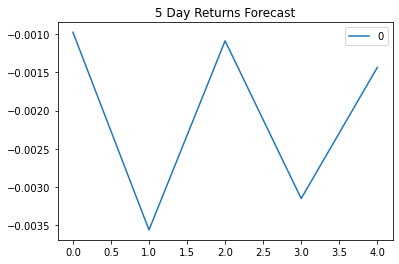

In [12]:
# Plot the 5 Day Returns Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Returns Forecast")

Based on the p-value, this ARMA model isn't a great fit as only the AR and MA lag 1 values are under our 0.05 threshold. Therefore I may be using unreliable coefficients that are going to lead to misleading results.

---

# ARIMA Model: Forecasting the Exchange Rate Price

 1. Using the *raw* CAD/JPY exchange rate price, I will estimate an ARIMA model. To start, I will set P=5, D=1, and Q=1 in the model (ARIMA(df, order=(5,1,1))
 2. I will output the ARIMA summary table and take note of the p-values of the lags. Based again on a threshold of <0.05 for the p-values I will then determine   whether this model is a good fit.
 3. Finally I will construct a 5 day forecast for the Exchange Rate Price. 

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Estimate ARIMA Model:
model = ARIMA(cad_jpy_df["Price"], order=(5,1,1))

# Fit the model
results = model.fit()

C:\Users\savag\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Users\savag\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [14]:
# Output model summary results:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Price   No. Observations:                 7928
Model:                 ARIMA(5, 1, 1)   Log Likelihood               -8745.622
Method:                       css-mle   S.D. of innovations              0.729
Date:                Thu, 20 Aug 2020   AIC                          17507.244
Time:                        12:05:16   BIC                          17563.070
Sample:                             1   HQIC                         17526.361
                                                                              
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0058      0.008     -0.743      0.458      -0.021       0.009
ar.L1.D.Price     0.4287      0.246      1.740      0.082      -0.054       0.912
ar.L2.D.Price     0.0177      0.014      1.264      0.206      -0.010       0.045
ar.L3.D.Price    -0.0118      0.012     -0.959      0.337      -0.036       0.012
ar.L4.D.Price     0.0110      0.012      0.879      0.379      -0.013       0.035
ar.L5.D.Price    -0.0191      0.011     -1.702      0.089      -0.041       0.003
ma.L1.D.Price    -0.4568      0.246     -1.855      0.064      -0.939       0.026
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.7660           -0.7702j            1.9266           -0.0655
AR.2            1.7660           +0.7702j            1.9266            0.0655
AR.3           -2.3649           -0.0000j            2.3649           -0.5000
AR.4           -0.2974           -2.4212j            2.4394           -0.2695
AR.5           -0.2974           +2.4212j            2.4394            0.2695
MA.1            2.1893           +0.0000j            2.1893            0.0000
-----------------------------------------------------------------------------
"""

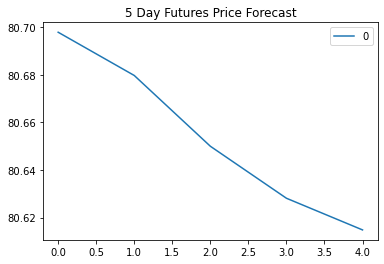

In [15]:
# Plot the 5 Day Price Forecast
pd.DataFrame(results.forecast(steps=5)[0]).plot(title="5 Day Futures Price Forecast")

Based on the model results, we would expect the Japanese Yen to decline against CAD over the next 5 days. However judging from the pvalues, this is a poor model as none of the coefficients had p-values under our statistically significant threshold of 0.05.

---

# Volatility Forecasting with GARCH

Here I will use the GARCH model to forecast near-term volatility of the CAD/JPY daily returns. 

Using futures Settle *Returns*, I will estimate a GARCH model as follows:

1. First I will create a GARCH model and fit it to the returns data. I will set the parameters to p=2 and q=1: order=(2, 1).
2. I will then output the GARCH summary table and take note of the p-values of the lags. Once again using a significance threshold of <0.05.
3. Lastly, I will plot the 5-day forecast of the volatility.

In [16]:
from arch import arch_model

In [17]:
# Estimate a GARCH model:
model = arch_model(returns, mean="Zero", vol="GARCH", p=2, q=1)

# Fit the model
results_garch = model.fit(disp="off")

In [18]:
# Summarize the model results
results_garch.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Zero Mean - GARCH Model Results                        
==============================================================================
Dep. Variable:                  Price   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8911.02
Distribution:                  Normal   AIC:                           17830.0
Method:            Maximum Likelihood   BIC:                           17858.0
                                        No. Observations:                 7928
Date:                Thu, Aug 20 2020   Df Residuals:                     7924
Time:                        12:05:20   Df Model:                            4
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      9.0733e-03  2.545e-03      3.566  3.628e-04  [4.086e-03,1.406e-02]
alpha[1]       0.0624  1.835e-02      3.402  6.682e-04  [2.647e-02,9.841e-02]
alpha[2]       0.0000  2.010e-02      0.000      1.000 [-3.940e-02,3.940e-02]
beta[1]        0.9243  1.229e-02     75.205      0.000      [  0.900,  0.948]
=============================================================================

Covariance estimator: robust
"""

The p-values for the GARCH model are far lower than the ARMA/ARIMA. Outside the of the alpha(2) p-value, all are significant, indicating overall a much better model performance.

In [19]:
# Find the last day of the dataset
last_day = returns.index.max().strftime('%Y-%m-%d')
last_day

'2020-06-04'

In [20]:
# Create a 5 day forecast of volatility
forecast_horizon = 5
# Start the forecast using the last_day calculated above
forecasts = results_garch.forecast(start='2020-06-04', horizon=forecast_horizon)
forecasts

In [21]:
# Annualize the forecast
intermediate = np.sqrt(forecasts.variance.dropna() * 252)
intermediate.head()

,h.1,h.2,h.3,h.4,h.5
Date,,,,,
2020-06-04,12.566035,12.573725,12.581308,12.588786,12.596161


In [22]:
# Transpose the forecast so that it is easier to plot
final = intermediate.dropna().T
final.head()

Date,2020-06-04
h.1,12.566035
h.2,12.573725
h.3,12.581308
h.4,12.588786
h.5,12.596161


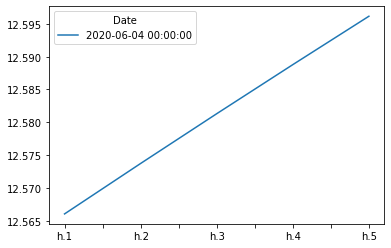

In [23]:
# Plot the final forecast
final.plot()

Based on the graph above, the forecast for CAD/JPY volatility is that it is expected to rise over the next 5 days. 

---

# Conclusions

*Based on your time series analysis, would you buy the yen now?* 

Based on the ARIMA model, the Yen is expected to strengthen slightly over the next 5 days. 

*Is the risk of the yen expected to increase or decrease?*

The GARCH model expects the CAD/JPY volatility to tick up over the next 5 days.

*Based on the model evaluation, would you feel confident in using these models for trading?*

The p-values for most, if not all the coefficients, on my ARMA/ARIMA models are not significant. So I would like to rework the models before I'd feel comfortable using these as part of my investment process.
